### Import all dependencies and Preprocess Data

In [98]:
import pandas as pd
import re
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

### Data Loading and Merging

In [99]:
def load_excel_and_clean(path, value_name):
    # Extract the year from the filename
    match = re.search(r"(2019|2020|2021)", path)
    if match:
        year = int(match.group(0))
    else:
        raise ValueError("Year not found in the filename. Expected 2019, 2020, or 2021.")

    # Read all sheets
    xls = pd.read_excel(path, sheet_name=None)
    all_months = []

    for sheet_name, df in xls.items():
        # Clean column names
        df.columns = (
            df.columns.str.strip()
                      .str.lower()
                      .str.replace(' ', '_', regex=False)
        )

        df['month'] = sheet_name  # Add month from sheet name
        id_vars = ['circle', 'district', '33kv_feeder', 'month']

        # Identify columns like 'day_1', 'day_2', etc.
        day_cols = [c for c in df.columns if c.startswith('day_')]
        
        # Melt to long format
        df_long = df.melt(
            id_vars=id_vars,
            value_vars=day_cols,
            var_name='day',
            value_name=value_name
        )

        # Clean day column and convert to int
        df_long['day'] = df_long['day'].str.replace('day_', '').astype(int)

        # Convert month name to month number
        df_long['month'] = pd.to_datetime(df_long['month'], format='%b').dt.month

        # Construct datetime column
        df_long['date'] = pd.to_datetime({
            'year': year,
            'month': df_long['month'],
            'day': df_long['day']
        }, errors='coerce')  # coerce invalid dates like Feb 30 to NaT

        # Drop redundant columns
        df_long = df_long.drop(columns=['month', 'day'])

        all_months.append(df_long)

    # Concatenate all sheets
    final_df = pd.concat(all_months, ignore_index=True)

    # Optional: drop rows with invalid dates
    final_df = final_df.dropna(subset=['date'])

    return final_df

In [100]:
# List availability data paths (using relative paths from project root)
avail_path_2019 = os.path.join('..', 'data', '33KV Daily Availability 2019.xlsx')
avail_path_2020 = os.path.join('..', 'data', '33KV Daily Availability 2020.xlsx')
avail_path_2021 = os.path.join('..', 'data', '33KV Daily Availability 2021.xlsx')

# List consumption data paths (using relative paths from project root)
cons_path_2019 = os.path.join('..', 'data', '33KV Daily Consumption 2019.xlsx')
cons_path_2020 = os.path.join('..', 'data', '33KV Daily Consumption 2020.xlsx')
cons_path_2021 = os.path.join('..', 'data', '33KV Daily Consumption 2021.xlsx')



In [101]:
#Load Availability data
avail_2019 = load_excel_and_clean(avail_path_2019, 'availability_hrs')
avail_2020 = load_excel_and_clean(avail_path_2020, 'availability_hrs')
avail_2021 = load_excel_and_clean(avail_path_2021, 'availability_hrs')

#Load Consumption data
cons_2019 = load_excel_and_clean(cons_path_2019, 'consumption_mwh')
cons_2020 = load_excel_and_clean(cons_path_2020, 'consumption_mwh')
cons_2021 = load_excel_and_clean(cons_path_2021, 'consumption_mwh')


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Web Extension extension is not supported and will be removed
  warn(msg)


In [102]:
# Inspect all availability and consumption shapes
#Inspect availability data shapes
print(f"Availability_2019 rows: {avail_2019.shape[0]}")
print(f"Availability_2020 rows: {avail_2020.shape[0]}")
print(f"Availability_2021 rows: {avail_2021.shape[0]}")

#Inspect consumption data shapes
print(f"Consumption_2019 rows: {cons_2019.shape[0]}")
print(f"Consumption_2020 rows: {cons_2020.shape[0]}")
print(f"Consumption_2021 rows: {cons_2021.shape[0]}")

Availability_2019 rows: 31755
Availability_2020 rows: 32632
Availability_2021 rows: 30060
Consumption_2019 rows: 31816
Consumption_2020 rows: 32574
Consumption_2021 rows: 30394


In [103]:
#merge all availability data
avail_all = pd.concat([avail_2019, avail_2020, avail_2021], ignore_index=True)
#merge all consumption data
cons_all = pd.concat([cons_2019, cons_2020, cons_2021], ignore_index=True)
# Inspect merged availability and consumption shapes
print(f"Availability_all rows: {avail_all.shape[0]}")
print(f"Consumption_all rows: {cons_all.shape[0]}")

Availability_all rows: 94447
Consumption_all rows: 94784


In [104]:
avail_all

,circle,district,33kv_feeder,availability_hrs,date
0,CENTRAL,APAPA,AMUWO LOCAL T3,24.0,2019-01-01
1,CENTRAL,APAPA,APAPA MAINS 1,24.0,2019-01-01
2,CENTRAL,APAPA,APAPA MAINS 2,24.0,2019-01-01
3,CENTRAL,APAPA,APAPA ROAD LOCAL T1,21.0,2019-01-01
4,CENTRAL,APAPA,APAPA ROAD LOCAL T2,24.0,2019-01-01
...,...,...,...,...,...
94442,WEST,OJO,FESTAC 1 (OJO),8.0,2021-11-30
94443,WEST,OJO,OJO LOCAL T1,24.0,2021-11-30
94444,WEST,OJO,OJO LOCAL T2,0.0,2021-11-30
94445,WEST,OJO,OJO LOCAL T3,24.0,2021-11-30


In [105]:
cons_all

,circle,district,33kv_feeder,consumption_mwh,date
0,CENTRAL,APAPA,AMUWO LOCAL T3,191.0,2019-01-01
1,CENTRAL,APAPA,APAPA MAINS 1,75.0,2019-01-01
2,CENTRAL,APAPA,APAPA MAINS 2,22.0,2019-01-01
3,CENTRAL,APAPA,APAPA ROAD LOCAL T1,135.3,2019-01-01
4,CENTRAL,APAPA,APAPA ROAD LOCAL T2,192.3,2019-01-01
...,...,...,...,...,...
94779,WEST,OJO,FESTAC 1 (OJO),119.0,2021-11-30
94780,WEST,OJO,OJO LOCAL T1,119.2,2021-11-30
94781,WEST,OJO,OJO LOCAL T2,0.0,2021-11-30
94782,WEST,OJO,OJO LOCAL T3,120.9,2021-11-30


In [106]:
# Merge on circle, district, feeder, month, and day
df_merged = pd.merge(
    avail_all, 
    cons_all, 
    on=['date', 'circle', 'district', '33kv_feeder' ],
    how='inner'
)
    
# Preview merged data
df_merged.head()

,circle,district,33kv_feeder,availability_hrs,date,consumption_mwh
0,CENTRAL,APAPA,AMUWO LOCAL T3,24.0,2019-01-01,191.0
1,CENTRAL,APAPA,APAPA MAINS 1,24.0,2019-01-01,75.0
2,CENTRAL,APAPA,APAPA MAINS 2,24.0,2019-01-01,22.0
3,CENTRAL,APAPA,APAPA ROAD LOCAL T1,21.0,2019-01-01,135.3
4,CENTRAL,APAPA,APAPA ROAD LOCAL T2,24.0,2019-01-01,192.3


In [107]:
new_data = df_merged[df_merged['district'] == 'AGBARA'].reset_index(drop=True)
new_data.head()

,circle,district,33kv_feeder,availability_hrs,date,consumption_mwh
0,WEST,AGBARA,AGBARA 33,24.0,2019-01-01,274.7
1,WEST,AGBARA,AGBARA LOCAL T4,24.0,2019-01-01,146.5
2,WEST,AGBARA,AGBARA LOCAL T5,24.0,2019-01-01,185.3
3,WEST,AGBARA,AGBARA LOCAL T6,24.0,2019-01-01,26.4
4,WEST,AGBARA,BADAGRY 33,22.0,2019-01-01,217.7


In [108]:
len(new_data["33kv_feeder"].unique())

9

In [109]:
new_data = new_data.drop(columns=['circle', 'district'])
# rename 33kv_feeder to feeder_name
new_data = new_data.rename(columns={'33kv_feeder': 'feeder_name'})
new_data.head()

,feeder_name,availability_hrs,date,consumption_mwh
0,AGBARA 33,24.0,2019-01-01,274.7
1,AGBARA LOCAL T4,24.0,2019-01-01,146.5
2,AGBARA LOCAL T5,24.0,2019-01-01,185.3
3,AGBARA LOCAL T6,24.0,2019-01-01,26.4
4,BADAGRY 33,22.0,2019-01-01,217.7


In [110]:
# Reorder columns to make 'date' the first column
cols = ['date'] + [col for col in new_data.columns if col != 'date']
new_data = new_data[cols]
new_data

,date,feeder_name,availability_hrs,consumption_mwh
0,2019-01-01,AGBARA 33,24.0,274.7
1,2019-01-01,AGBARA LOCAL T4,24.0,146.5
2,2019-01-01,AGBARA LOCAL T5,24.0,185.3
3,2019-01-01,AGBARA LOCAL T6,24.0,26.4
4,2019-01-01,BADAGRY 33,22.0,217.7
...,...,...,...,...
9580,2021-11-30,BADAGRY 33,11.0,107.7
9581,2021-11-30,BADAGRY EXPRESS,24.0,66.0
9582,2021-11-30,GUINEA (BETA) GLASS,24.0,68.8
9583,2021-11-30,OKO AFO,24.0,199.2


In [111]:
# Create cleaned_data directory using relative path
clean_data_path = os.path.join('..', 'cleaned_data')
if not os.path.exists(clean_data_path):
    os.makedirs(clean_data_path)

# Save the merged DataFrame to a CSV file
new_data.to_csv(os.path.join(clean_data_path, 'agbara_data.csv'), index=False)
print(f"Data saved to: {os.path.join(clean_data_path, 'agbara_data.csv')}")

Data saved to: ..\cleaned_data\agbara_data.csv


In [112]:
data_stat= new_data.describe()
data_stat.to_csv(os.path.join(clean_data_path, 'raw_data_stat.csv'))

In [113]:
new_data.isnull().sum()

date                0
feeder_name         0
availability_hrs    0
consumption_mwh     0
dtype: int64

### Feature Engineering

In [114]:
new_data["feeder_name"].unique()

array(['AGBARA 33', 'AGBARA LOCAL T4', 'AGBARA LOCAL T5',
       'AGBARA LOCAL T6', 'BADAGRY 33', 'BADAGRY EXPRESS',
       'GUINEA (BETA) GLASS', 'OKO AFO', 'RYDER GLASS'], dtype=object)

In [115]:
# Map feeders to area types

feeder_area_map = {
    "AGBARA 33": "Industrial",
    "AGBARA LOCAL T4": "Residential",
    "AGBARA LOCAL T5": "Residential",
    "AGBARA LOCAL T6": "Residential",
    "BADAGRY 33": "Commercial",
    "BADAGRY EXPRESS": "Commercial",
    "GUINEA (BETA) GLASS": "Industrial",
    "OKO AFO": "Residential",
    "RYDER GLASS": "Industrial"
}

new_data["feeder_type"] = new_data["feeder_name"].map(feeder_area_map)
new_data

,date,feeder_name,availability_hrs,consumption_mwh,feeder_type
0,2019-01-01,AGBARA 33,24.0,274.7,Industrial
1,2019-01-01,AGBARA LOCAL T4,24.0,146.5,Residential
2,2019-01-01,AGBARA LOCAL T5,24.0,185.3,Residential
3,2019-01-01,AGBARA LOCAL T6,24.0,26.4,Residential
4,2019-01-01,BADAGRY 33,22.0,217.7,Commercial
...,...,...,...,...,...
9580,2021-11-30,BADAGRY 33,11.0,107.7,Commercial
9581,2021-11-30,BADAGRY EXPRESS,24.0,66.0,Commercial
9582,2021-11-30,GUINEA (BETA) GLASS,24.0,68.8,Industrial
9583,2021-11-30,OKO AFO,24.0,199.2,Residential


In [116]:
# Create additional time-based features
new_data["day_of_week"] = new_data["date"].dt.day_name()
new_data["month"] = new_data["date"].dt.month
new_data["is_weekend"] = new_data["day_of_week"].isin(["Saturday", "Sunday"]).astype(int)

# Create lag features
new_data = new_data.sort_values(["feeder_name", "date"])
new_data["lag1_avail"] = new_data.groupby("feeder_name")["availability_hrs"].shift(1)
# Drop rows where lag1 is NaN (first day for each feeder)
new_data = new_data.dropna(subset=["lag1_avail"]).reset_index(drop=True)



In [117]:
new_data.head()

,date,feeder_name,availability_hrs,consumption_mwh,feeder_type,day_of_week,month,is_weekend,lag1_avail
0,2019-01-02,AGBARA 33,24.0,267.0,Industrial,Wednesday,1,0,24.0
1,2019-01-03,AGBARA 33,10.0,104.2,Industrial,Thursday,1,0,24.0
2,2019-01-04,AGBARA 33,4.0,48.6,Industrial,Friday,1,0,10.0
3,2019-01-05,AGBARA 33,21.0,227.0,Industrial,Saturday,1,1,4.0
4,2019-01-06,AGBARA 33,21.0,225.5,Industrial,Sunday,1,1,21.0


In [118]:
# Save the merged DataFrame to a CSV file
new_data.to_csv(os.path.join(clean_data_path, 'new_data.csv'), index=False)
print(f"Data saved to: {os.path.join(clean_data_path, 'new_data.csv')}")

Data saved to: ..\cleaned_data\new_data.csv


### Exploratory Data Analysis (EDA)

In [119]:
# Convert 'availability_hrs' and 'consumption_mwh' column to numeric, coercing errors to NaN
new_data['availability_hrs'] = pd.to_numeric(new_data['availability_hrs'], errors='coerce')
new_data['consumption_mwh'] = pd.to_numeric(new_data['consumption_mwh'], errors='coerce')

In [120]:
#Give a statistical description of the data
new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9576 entries, 0 to 9575
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              9576 non-null   datetime64[ns]
 1   feeder_name       9576 non-null   object        
 2   availability_hrs  9576 non-null   float64       
 3   consumption_mwh   9576 non-null   float64       
 4   feeder_type       9576 non-null   object        
 5   day_of_week       9576 non-null   object        
 6   month             9576 non-null   int32         
 7   is_weekend        9576 non-null   int64         
 8   lag1_avail        9576 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int32(1), int64(1), object(3)
memory usage: 636.0+ KB


In [121]:
data_stat= new_data.describe()
data_stat.to_csv(os.path.join(clean_data_path, 'engineered_data_stat.csv'))


In [138]:
avg_consumption = new_data.groupby("feeder_type")["consumption_mwh"].mean()
avg_consumption

feeder_type
Commercial     68.609356
Industrial     65.703788
Residential    83.518442
Name: consumption_mwh, dtype: float64

In [139]:
avg_consumption["Healthcare"] = avg_consumption.mean()
avg_consumption   

feeder_type
Commercial     68.609356
Industrial     65.703788
Residential    83.518442
Healthcare     72.610529
Name: consumption_mwh, dtype: float64

In [140]:
max_avail = new_data['availability_hrs'].max()
max_avail

np.float64(24.0)

In [141]:
# Find the maximum value in the 'consumption_mwh' column
max_cons = new_data['consumption_mwh'].max()
max_cons

np.float64(329.6000000000001)

In [142]:
# Check for missing values
new_data.isnull().sum()


date                0
feeder_name         0
availability_hrs    0
consumption_mwh     0
feeder_type         0
day_of_week         0
month               0
is_weekend          0
lag1_avail          0
dtype: int64

#### Availability Hours Distribution

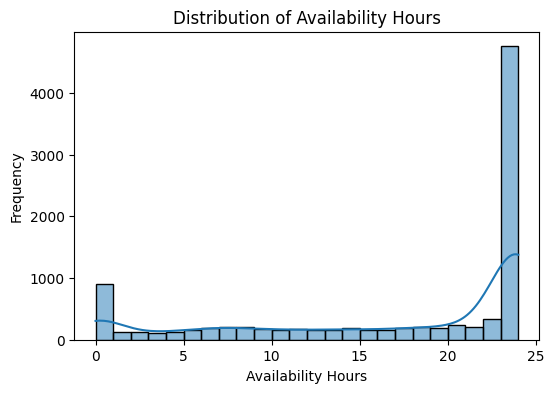

In [127]:
plt.figure(figsize=(6,4))
sns.histplot(new_data["availability_hrs"], bins=24, kde=True)
plt.title("Distribution of Availability Hours")
plt.xlabel("Availability Hours")
plt.ylabel("Frequency")
plt.show()


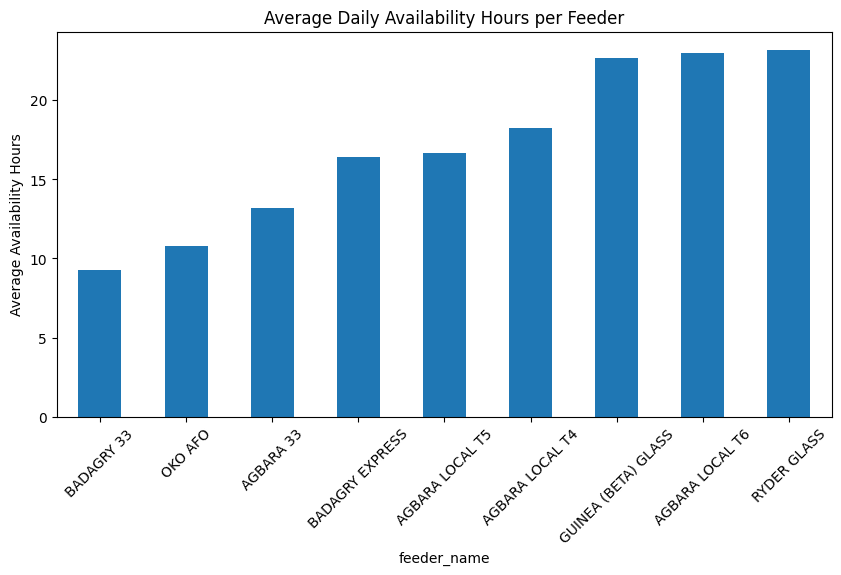

In [128]:
plt.figure(figsize=(10,5))
new_data.groupby("feeder_name")["availability_hrs"].mean().sort_values().plot(kind="bar")
plt.title("Average Daily Availability Hours per Feeder")
plt.ylabel("Average Availability Hours")
plt.xticks(rotation=45)
plt.show()


#### Consumption vs Availability of Feeders

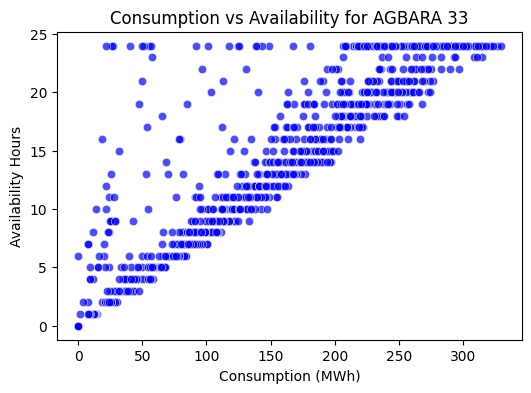

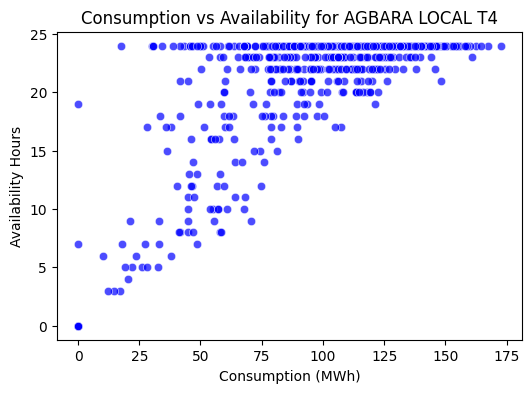

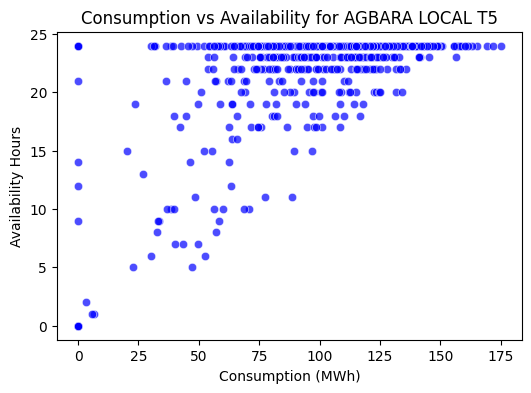

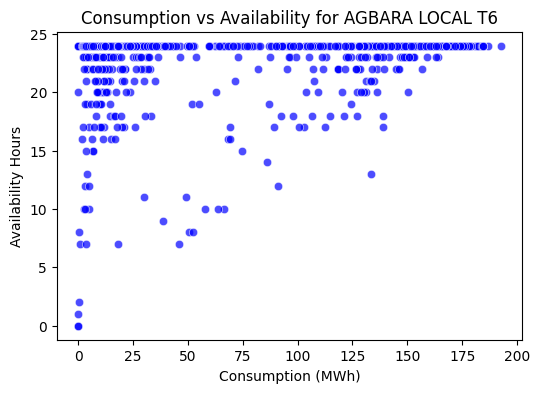

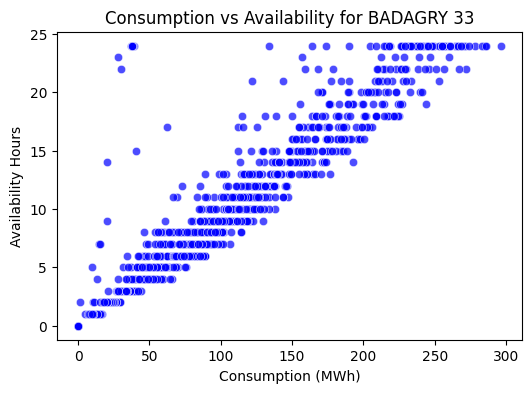

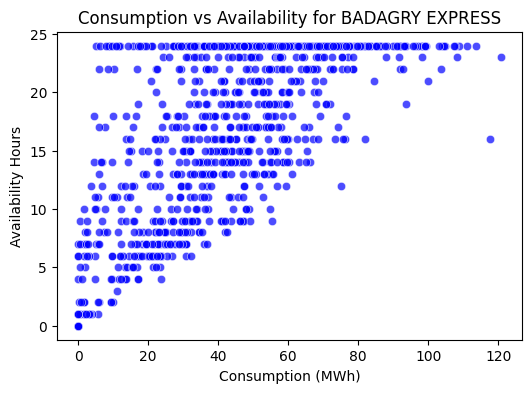

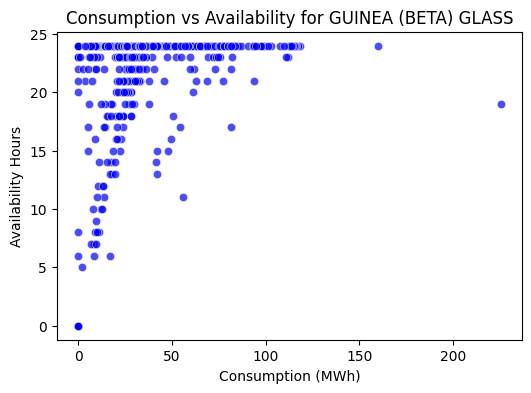

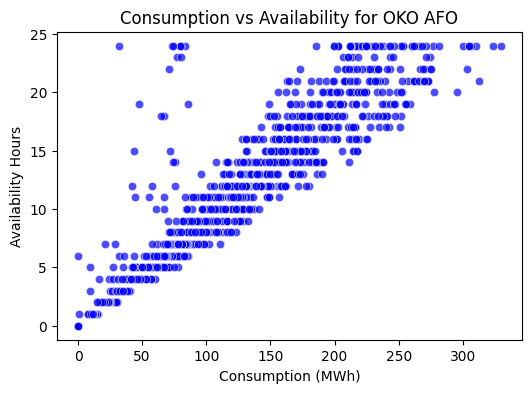

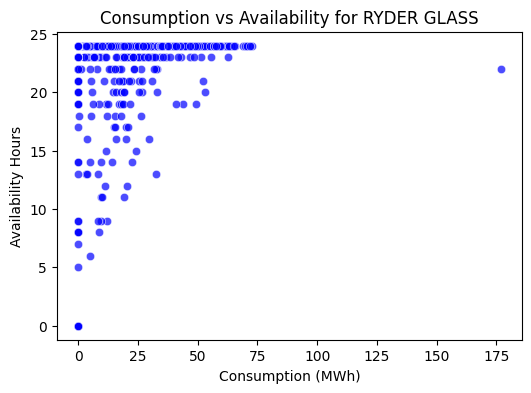

In [129]:
for feeder in new_data["feeder_name"].unique():
    subset = new_data[new_data["feeder_name"] == feeder]
    plt.figure(figsize=(6,4))
    sns.scatterplot(x="consumption_mwh", y="availability_hrs", data=subset, alpha=0.7, color="blue")
    plt.title(f"Consumption vs Availability for {feeder}")
    plt.xlabel("Consumption (MWh)")
    plt.ylabel("Availability Hours")
    plt.show()


#### Time Series Trends of Feeder's Availability

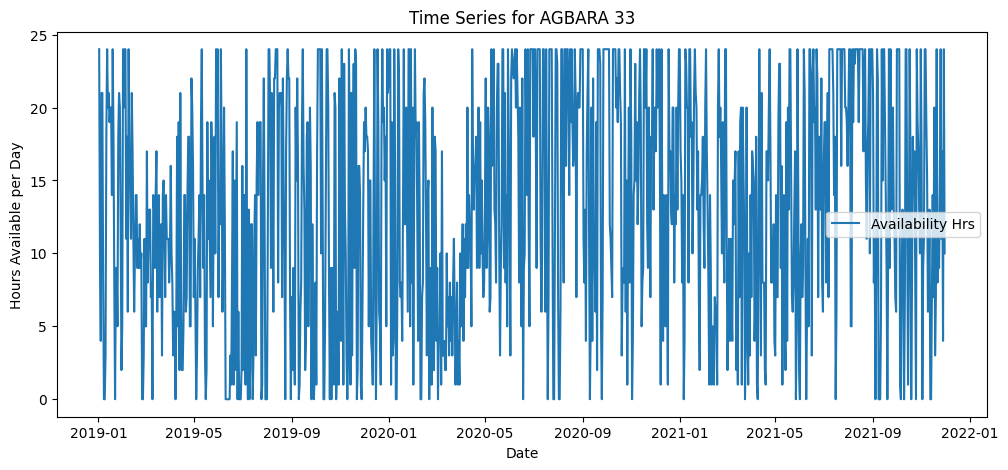

In [130]:
sample_feeder = "AGBARA 33"
df_sample = new_data[new_data["feeder_name"] == sample_feeder]

plt.figure(figsize=(12,5))
plt.plot(df_sample["date"], df_sample["availability_hrs"], label="Availability Hrs")
plt.title(f"Time Series for {sample_feeder}")
plt.xlabel("Date")
plt.ylabel("Hours Available per Day")
plt.legend()
plt.show()


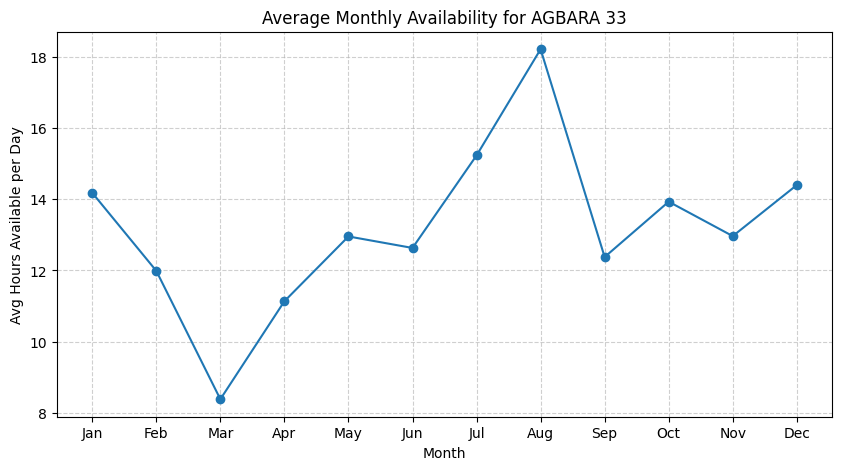

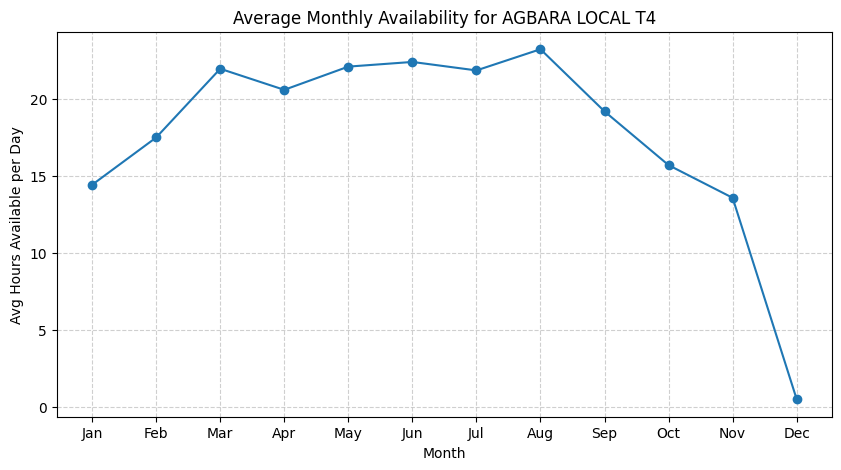

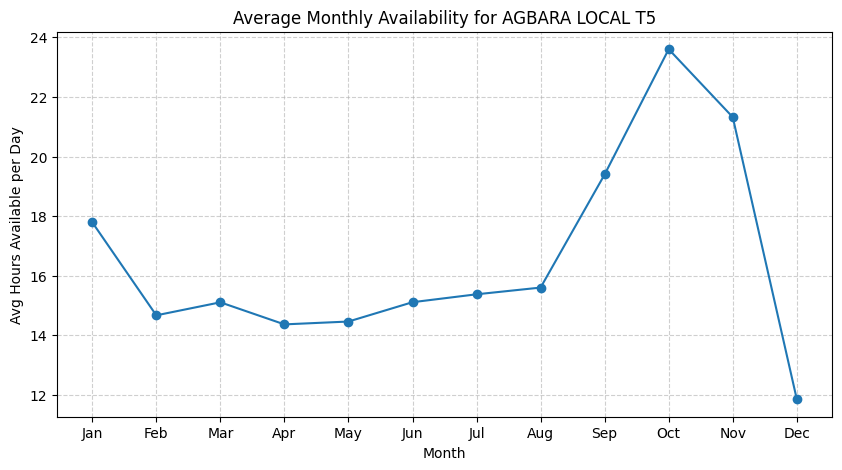

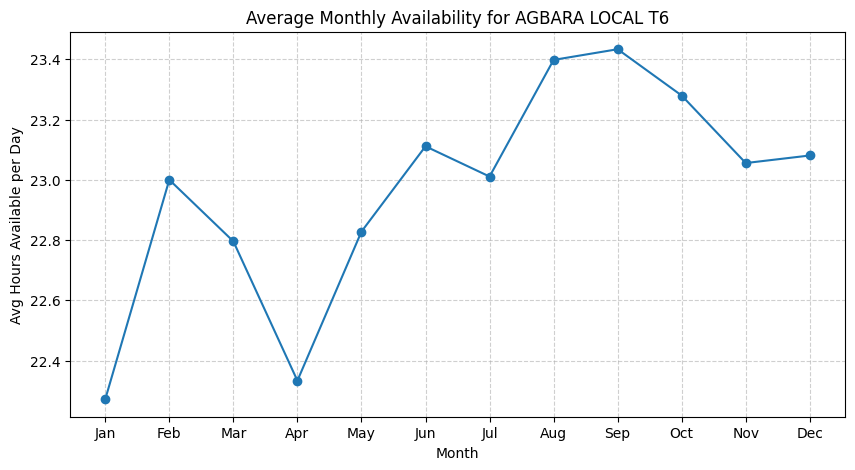

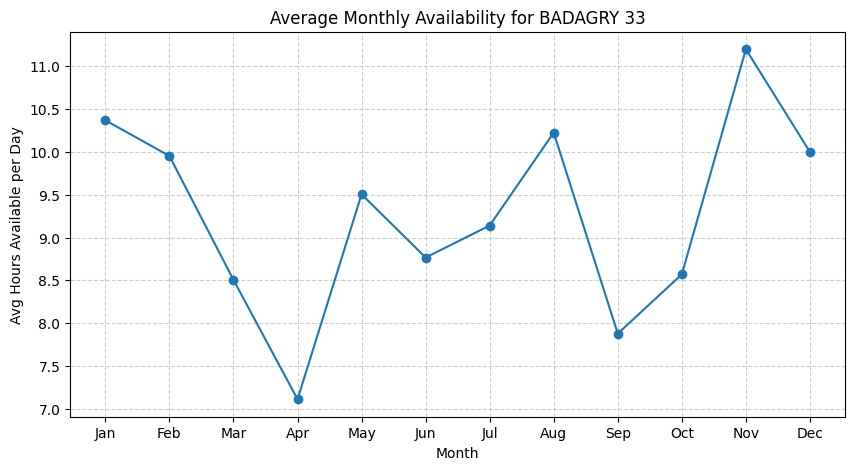

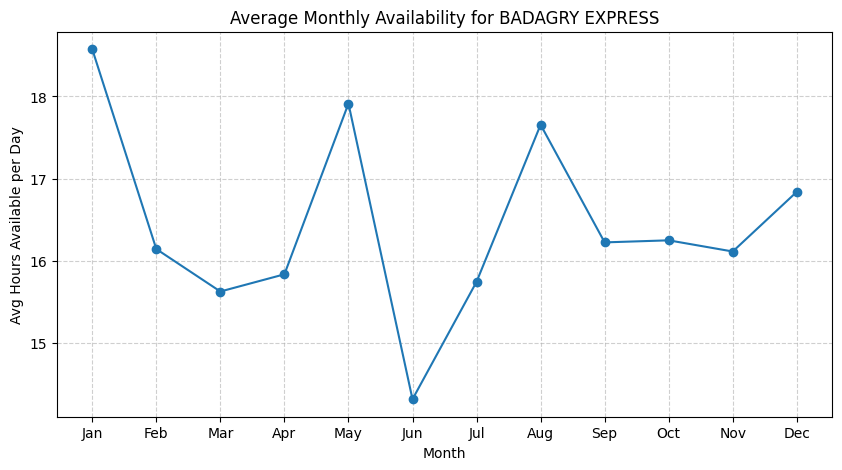

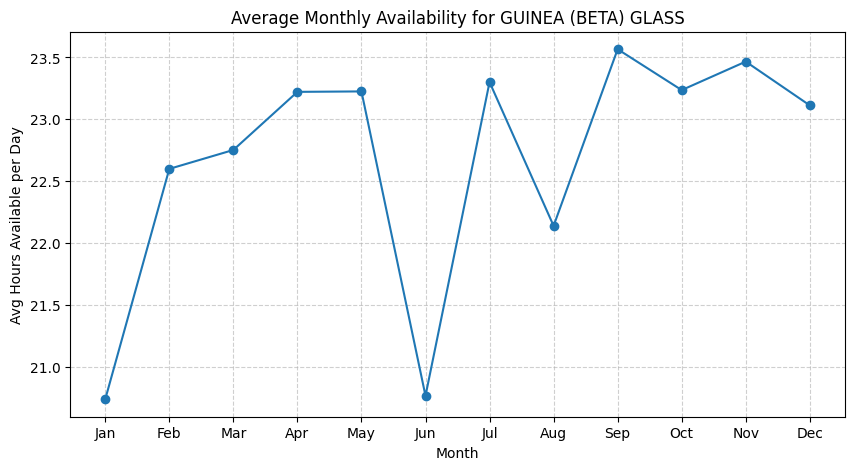

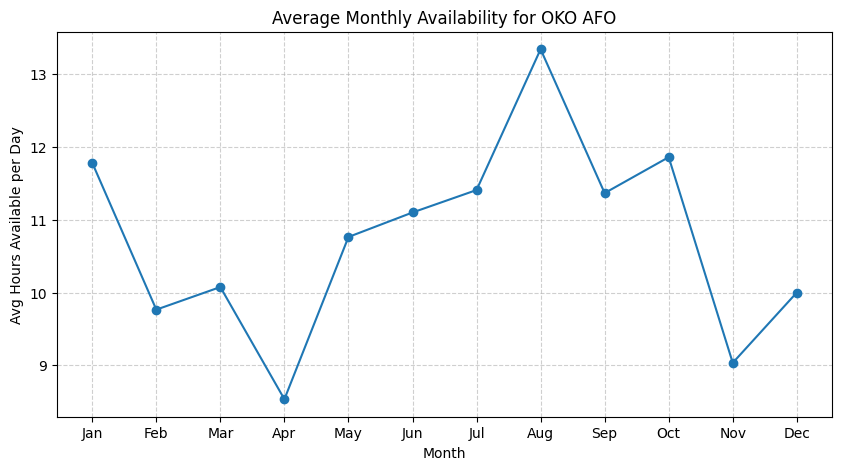

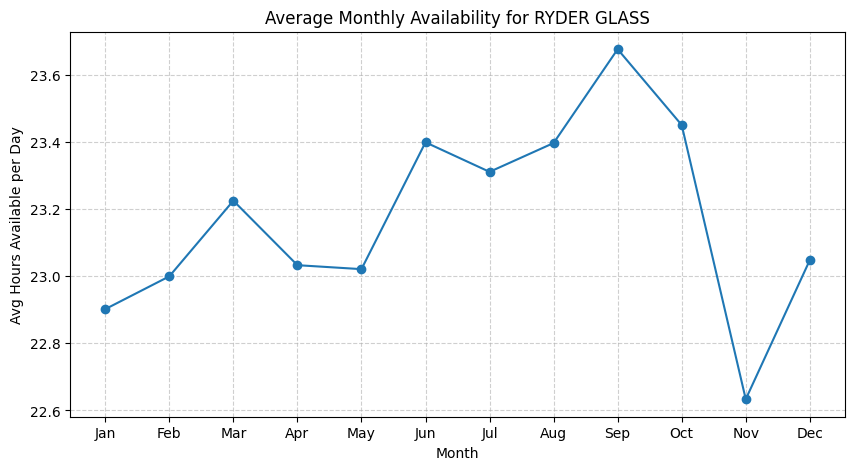

In [131]:
import calendar

# Get all unique feeders
feeders = new_data["feeder_name"].unique()

for feeder in feeders:
    df_sample = new_data[new_data["feeder_name"] == feeder].copy()
    
    # Group by calendar month (1–12) and take average across all years
    df_monthly = df_sample.groupby("month")["availability_hrs"].mean().reset_index()
    
    # Map numeric months to names
    df_monthly["month_name"] = df_monthly["month"].apply(lambda x: calendar.month_abbr[x])
    
    # Plot
    plt.figure(figsize=(10,5))
    plt.plot(df_monthly["month_name"], df_monthly["availability_hrs"], marker="o", color="tab:blue")
    plt.title(f"Average Monthly Availability for {feeder}")
    plt.xlabel("Month")
    plt.ylabel("Avg Hours Available per Day")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()

In [132]:
# feeders= new_data["feeder_name"].unique()

# for feeder in feeders:
#     df_sample = new_data[new_data["feeder_name"] == feeder].copy()
#     df_monthly = df_sample.resample("ME", on="date")["availability_hrs"].mean().reset_index()
    
#     plt.figure(figsize=(12,5))
#     plt.plot(df_monthly["date"], df_monthly["availability_hrs"], marker='o')
#     plt.title(f"Monthly Average Availability for {feeder}")
#     plt.xlabel("Month")
#     plt.ylabel("Average Availability Hours")
#     plt.grid()
#     plt.show()

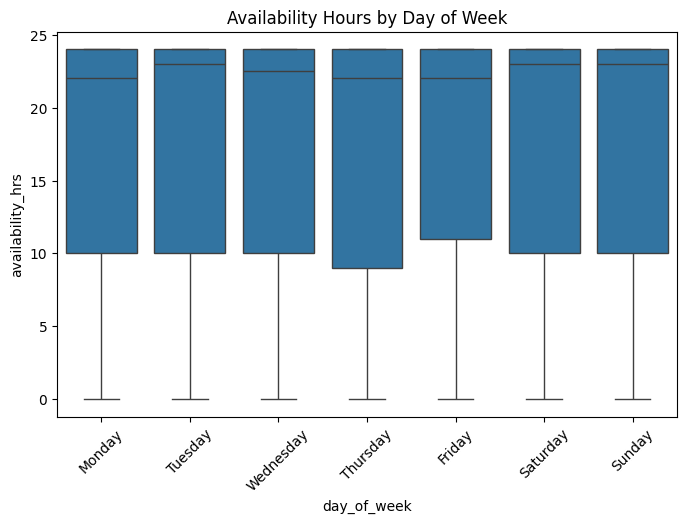

In [133]:
plt.figure(figsize=(8,5))
sns.boxplot(x="day_of_week", y="availability_hrs", data=new_data,
            order=["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"])
plt.title("Availability Hours by Day of Week")
plt.xticks(rotation=45)
plt.show()


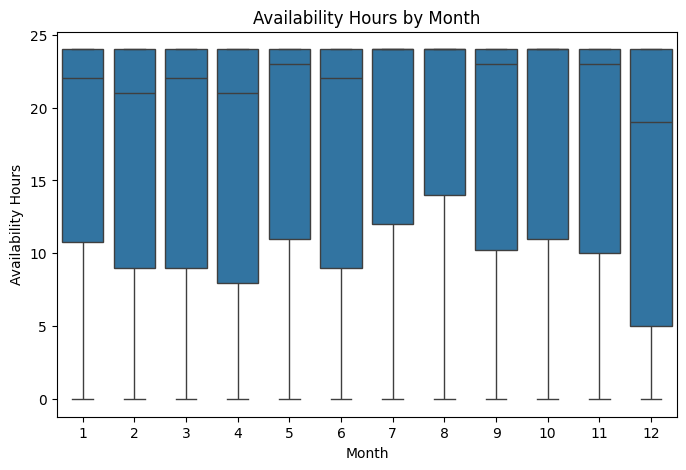

In [134]:
plt.figure(figsize=(8,5))
sns.boxplot(x="month", y="availability_hrs", data=new_data)
plt.title("Availability Hours by Month")
plt.xlabel("Month")
plt.ylabel("Availability Hours")
plt.show()


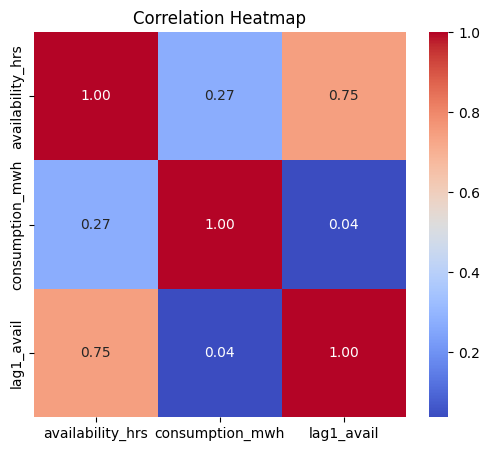

In [135]:
plt.figure(figsize=(6,5))
sns.heatmap(new_data[["availability_hrs","consumption_mwh","lag1_avail"]].corr(),
            annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


In [136]:
df_merged

,circle,district,33kv_feeder,availability_hrs,date,consumption_mwh
0,CENTRAL,APAPA,AMUWO LOCAL T3,24.0,2019-01-01,191.0
1,CENTRAL,APAPA,APAPA MAINS 1,24.0,2019-01-01,75.0
2,CENTRAL,APAPA,APAPA MAINS 2,24.0,2019-01-01,22.0
3,CENTRAL,APAPA,APAPA ROAD LOCAL T1,21.0,2019-01-01,135.3
4,CENTRAL,APAPA,APAPA ROAD LOCAL T2,24.0,2019-01-01,192.3
...,...,...,...,...,...,...
94384,WEST,OJO,FESTAC 1 (OJO),8.0,2021-11-30,119.0
94385,WEST,OJO,OJO LOCAL T1,24.0,2021-11-30,119.2
94386,WEST,OJO,OJO LOCAL T2,0.0,2021-11-30,0.0
94387,WEST,OJO,OJO LOCAL T3,24.0,2021-11-30,120.9
